<a href="https://colab.research.google.com/github/SHREY01022004/Customer-Segmentation-Analysis/blob/main/Cust_segmentation_online_retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation

We will be using E-commerce dataset of user purchases and try develop a model that allow us to do two things:

1. Classifying customers into segments.
2. Anticipate the purchases that will be made by a new customer, during the following year and
   this, from its first purchase by assigning them appropriate cluster/segment


## Import dependancies**

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode,iplot
#init_notebook_mode(connected=True)
#warnings.filterwarnings("ignore")
#plt.rcParams["patch.force_edgecolor"] = True
#plt.style.use('fivethirtyeight')
#mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## **Data Preparation**

In [5]:
# read the datafile
df_initial = pd.read_csv('/content/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])




Dataframe dimensions: (225826, 8)


In [6]:
# show first lines
display(df_initial[:5])

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                  WHITE METAL LANTERN       6.0   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

## **Exploratory Data Analysis**

### Identify null values

In [8]:
# gives some infomation on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = pd.concat([tab_info,
                       pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'})]) # Use pd.concat to combine DataFrames
tab_info = pd.concat([tab_info,
                       pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'})])
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print
display(tab_info)

---------- Display information about column types and number of null values ----------


InvoiceNo StockCode Description  Quantity     InvoiceDate  \
column type         object    object      object   float64  datetime64[ns]   
null values (nb)         0         1         866         1               1   
null values (%)        0.0  0.000443    0.383481  0.000443        0.000443   

                 UnitPrice CustomerID   Country  
column type        float64     object    object  
null values (nb)         1      63900         1  
null values (%)   0.000443  28.296122  0.000443

### Remove data entries


In [10]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
# gives some information on columns types and number of null values
# gives some information on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = pd.concat([tab_info,
                       pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'})]) # Use pd.concat instead of append
tab_info = pd.concat([tab_info,
                       pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'})]) # Use pd.concat instead of append
display(tab_info)

Dataframe dimensions: (161926, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object  float64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0          0       0  
null values (%)        0.0        0.0     0.0

In [11]:
print('Duplicate data entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate data entries: 1856


### Exploring data attributes
---

#### **Exploring the data attribute : Country**

In [12]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(
    ['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of cuntries in dataframe: {}'.format(len(countries)))


No. of cuntries in dataframe: 36


In [13]:
temp_no_of_order_per_count = df_initial[['CustomerID','Country']].groupby(['Country']).count()
temp_no_of_order_per_count = temp_no_of_order_per_count.reset_index(drop = False)

print('-' * 10 + " Contry-wise order calculation "+ '-' * 10)
print
print (temp_no_of_order_per_count.sort_values(
    by='CustomerID', ascending=False).rename(index=str,
                                        columns={"CustomerID": "Country wise number of order"}))

---------- Contry-wise order calculation ----------
                 Country  Country wise number of order
34        United Kingdom                        142467
14               Germany                          4052
13                France                          3403
10                  EIRE                          2492
29                 Spain                          1049
23           Netherlands                           992
3                Belgium                           835
31           Switzerland                           690
26              Portugal                           598
0              Australia                           502
7                 Cyprus                           352
18                 Italy                           309
12               Finland                           299
6        Channel Islands                           287
19                 Japan                           245
24                Norway                           212
30           

#### **Exploring the data attribute : Customers and products**

The dataframe contains $\sim$400,000 entries. What are the number of users and products in these entries ?

In [14]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),
              }], columns = ['products', 'transactions', 'customers'],
              index = ['quantity'])

products  transactions  customers
quantity      3229          9779       2880

Now we need to explore the number of products purchased in every transaction

In [15]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12348    539318                  17
7      12348    541998                   6
8      12348    548955                   5
9      12350    543037                  17

#### **Analysis of cancelled orders**

We need to count the number of transactions corresponding to cancelled orders

In [16]:
nb_products_per_basket['order_cancelled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x:int('C' in x))
display(nb_products_per_basket[:5])


n1 = nb_products_per_basket['order_cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
percentage = (n1/n2)*100
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, percentage))

CustomerID InvoiceNo  Number of products  order_cancelled
0      12346    541431                   1                0
1      12346   C541433                   1                1
2      12347    537626                  31                0
3      12347    542237                  29                0
4      12347    549222                  24                0

Number of orders cancelled: 1736/9779 (17.75%) 


In [17]:
display(df_initial.sort_values('CustomerID')[:5])

InvoiceNo StockCode                     Description  Quantity  \
61624   C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR  -74215.0   
61619    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR   74215.0   
72259    542237     84992  72 SWEETHEART FAIRY CAKE CASES      24.0   
72258    542237     22196    SMALL HEART MEASURING SPOONS      12.0   
72257    542237     22729     ALARM CLOCK BAKELIKE ORANGE       4.0   

              InvoiceDate  UnitPrice CustomerID         Country  
61624 2011-01-18 10:17:00       1.04      12346  United Kingdom  
61619 2011-01-18 10:01:00       1.04      12346  United Kingdom  
72259 2011-01-26 14:30:00       0.55      12347         Iceland  
72258 2011-01-26 14:30:00       0.85      12347         Iceland  
72257 2011-01-26 14:30:00       3.75      12347         Iceland

From the above output, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries.
To do this, I decide to locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (**CustomerID**, **Description** and **UnitPrice**):

In [18]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1])
                & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity           -1.0
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [19]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1])
                & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                  -1.0
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were  performed before December 2010 (the point of entry of the database). Below, I make a census of the cancel orders and check for the existence of counterparts:

In [20]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) &
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) &
                         (df_initial['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0):
        doubtfull_entry.append(index)

    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)

    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In the above function, I checked the two cases:
1. a cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity


In [21]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 2983
doubtfull_entry: 868


In [22]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 7


InvoiceNo StockCode                   Description  Quantity  \
77598    C542742    84535B  FAIRY CAKES NOTEBOOK A6 SIZE     -94.0   
90444    C544038     22784         LANTERN CREAM GAZEBO       -4.0   
111968   C545852     22464   HANGING METAL HEART LANTERN      -5.0   
116064   C546191    47566B        TEA TIME PARTY BUNTING     -35.0   
132642   C547675     22263       FELT EGG COSY LADYBIRD      -49.0   

               InvoiceDate  UnitPrice CustomerID         Country  \
77598  2011-01-31 16:26:00       0.65      15358  United Kingdom   
90444  2011-02-15 11:32:00       4.95      14659  United Kingdom   
111968 2011-03-07 13:49:00       1.65      14048  United Kingdom   
116064 2011-03-10 10:57:00       0.70      16422  United Kingdom   
132642 2011-03-24 14:07:00       0.66      17754  United Kingdom   

        QuantityCanceled  
77598                  0  
90444                  0  
111968                 0  
116064                 0  
132642                 0

In [23]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, QuantityCanceled]
Index: []



---

#### **Analysis of the StockCode**

Above, it has been seen that some values of the ** StockCode ** variable indicate a particular transaction (i.e. D for _Discount_). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [24]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS'], dtype=object)

In [25]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    




___
#### Analysis of Basket Price


I create a new variable that indicates the total price of every purchase:

In [26]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

InvoiceNo StockCode                     Description  Quantity  \
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR   74215.0   
220585    556201     22196    SMALL HEART MEASURING SPOONS      24.0   
220586    556201    84558A    3D DOG PICTURE PLAYING CARDS      18.0   
220587    556201    51014C          FEATHER PEN,COAL BLACK      12.0   
220588    556201     22727       ALARM CLOCK BAKELIKE RED        8.0   

               InvoiceDate  UnitPrice CustomerID         Country  \
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom   
220585 2011-06-09 13:01:00       0.85      12347         Iceland   
220586 2011-06-09 13:01:00       2.95      12347         Iceland   
220587 2011-06-09 13:01:00       0.85      12347         Iceland   
220588 2011-06-09 13:01:00       3.75      12347         Iceland   

        QuantityCanceled  TotalPrice  
61619              74215         0.0  
220585                 0        20.4  
220586                 0        53.1  
220587                 0        10.2  
220588                 0        30.0

In [27]:

# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

CustomerID InvoiceNo  Basket Price                   InvoiceDate
1      12347    537626        711.79 2010-12-07 14:57:00.000000000
2      12347    542237        475.39 2011-01-26 14:29:59.999999744
3      12347    549222        636.25 2011-04-07 10:43:00.000000000
4      12347    556201        382.52 2011-06-09 13:01:00.000000000
5      12348    539318        892.80 2010-12-16 19:09:00.000000000
6      12348    541998        227.44 2011-01-25 10:42:00.000000000

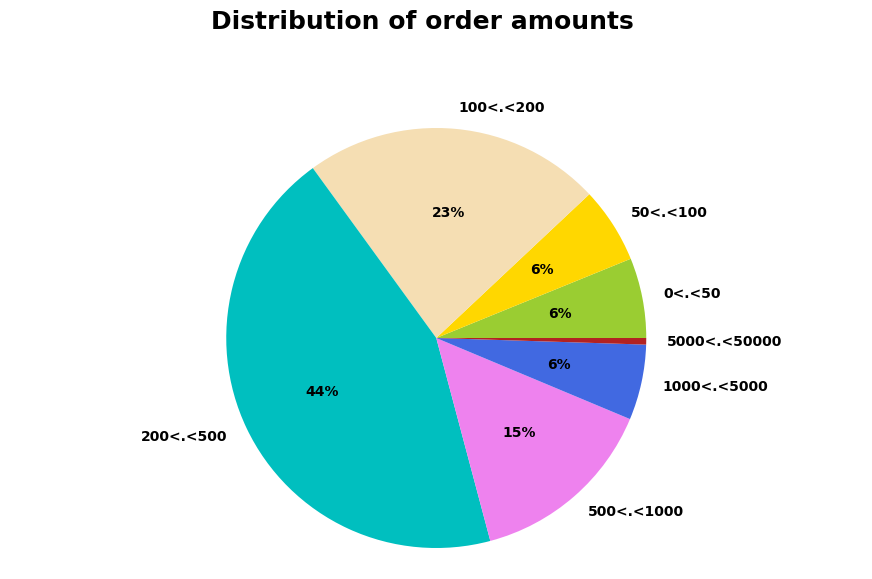

In [28]:
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

###  Analysis of the product categories

In the data-frame, products are uniquely identified through the **StockCode** variable. A short description of the products is given in the **Description** variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

#### Products Description


As a first step, I extract from the **Description** variable the information that will prove useful. To do this, I use the following function:

In [35]:


!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("number of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


This function takes as input the dataframe and analyzes the content of the **Description** column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [36]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [37]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

number of keywords in variable 'Description': 1360


The execution of this function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, I convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurrence:

In [38]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

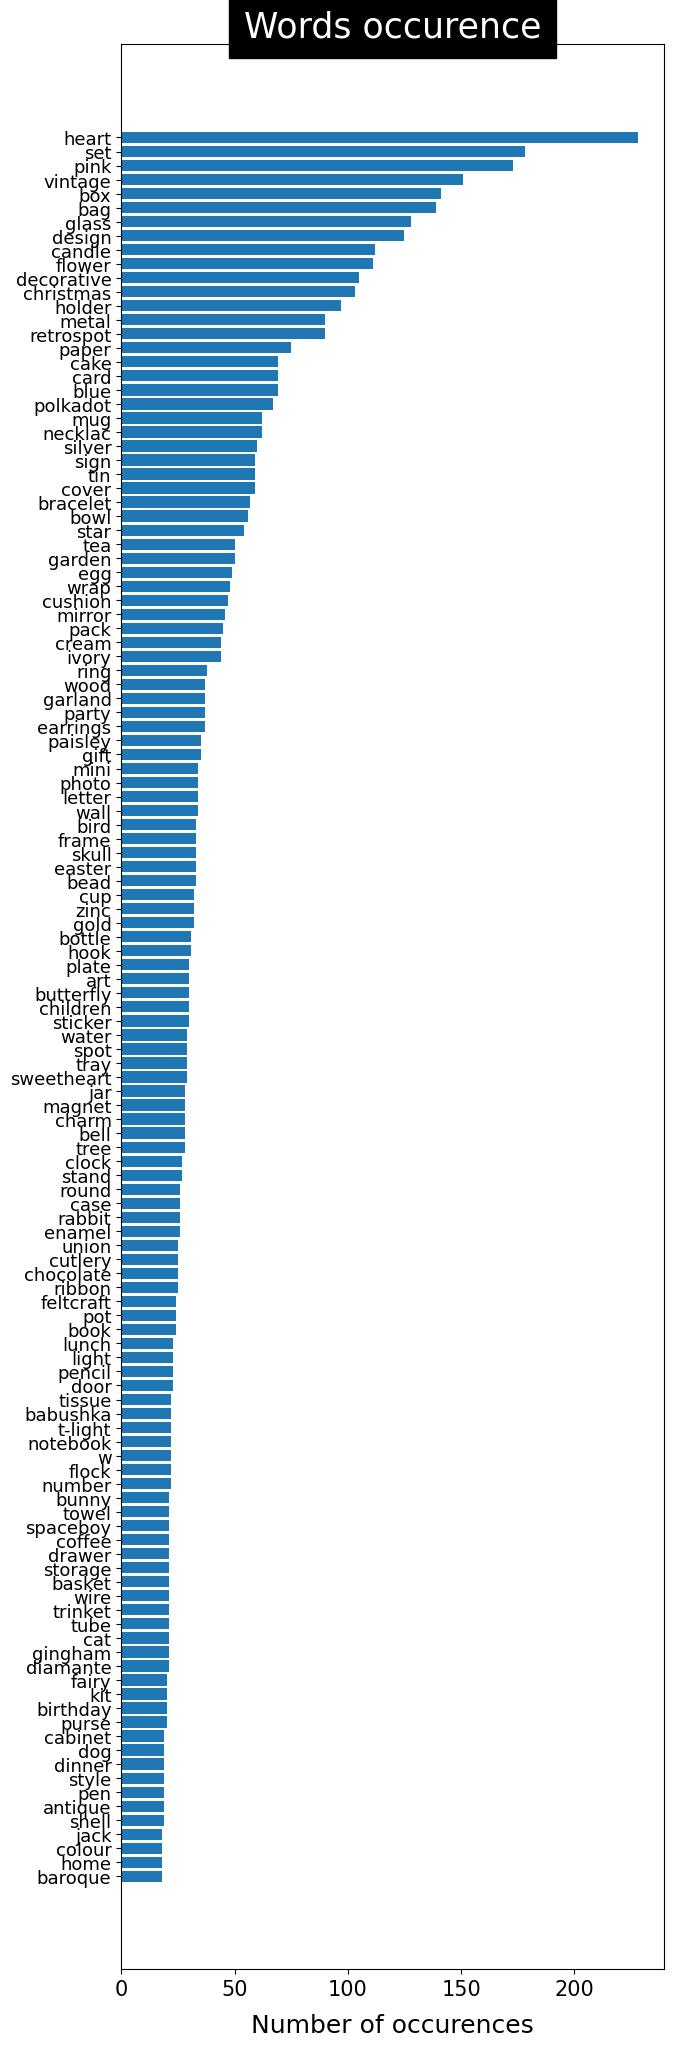

In [39]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### Defining product categories



In [40]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse = True)
print('Preserved words:', len(list_products))

Preserved words: 168


#### Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

   
|   | word  1  |  ...  | word j  | ...  | word N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

In [41]:
liste_produits = df_cleaned['Description'].unique()
#print(liste_produits[0:2])
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
#print(X[0:1])

<ipython-input-41-bc477d24a01b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
<ipython-input-41-bc477d24a01b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
<ipython-input-41-bc477d24a01b>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

* The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle.



* In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [42]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    #print(i)
    #print(col)
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    #print (prix)
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

<ipython-input-42-5204703b715f>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col] = 0
<ipython-input-42-5204703b715f>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col] = 0
<ipython-input-42-5204703b715f>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col] = 0
<

and to choose the appropriate ranges, I check the number of products in the different groups:

In [43]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       765                 
1<.<2       907                 
2<.<3       611                 
3<.<5       494                 
5<.<10      382                 
.>10        136                 


#### Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming).
In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [45]:
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10868582327121647
For n_clusters = 4 The average silhouette_score is : 0.13637286921842973
For n_clusters = 5 The average silhouette_score is : 0.15668956257319508
For n_clusters = 6 The average silhouette_score is : 0.1549504677326331
For n_clusters = 7 The average silhouette_score is : 0.17145848555877183
For n_clusters = 8 The average silhouette_score is : 0.1682134964870991
For n_clusters = 9 The average silhouette_score is : 0.15614132901933697


In [46]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)

    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.15668956257319508


#### Characterizing the content of clusters

I check the number of elements in every class:

In [47]:
pd.Series(clusters).value_counts()

0    907
1    765
4    611
3    518
2    494
Name: count, dtype: int64

In [48]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    #plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        #color = cm.spectral(float(i) / n_clusters) facecolor=color, edgecolor=color,
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

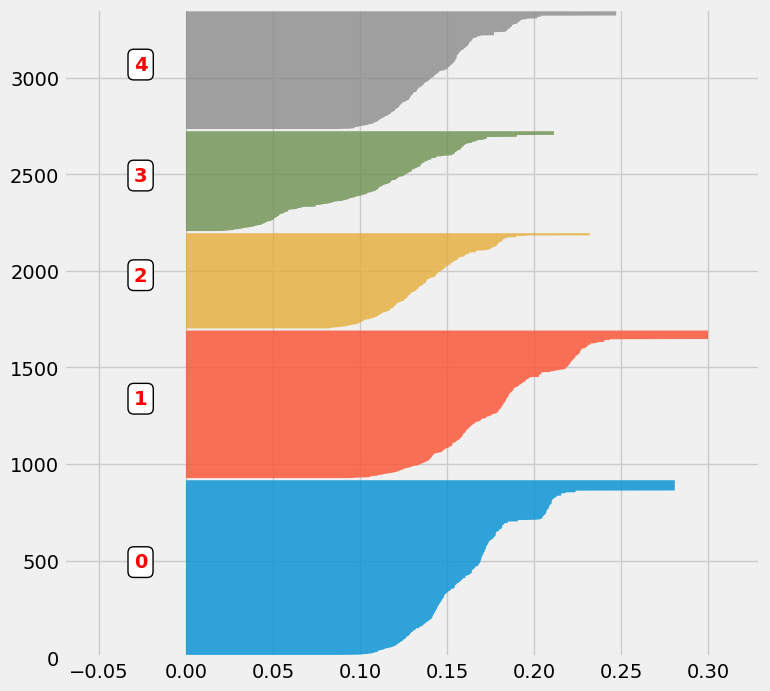

In [49]:

# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

** b: _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [50]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

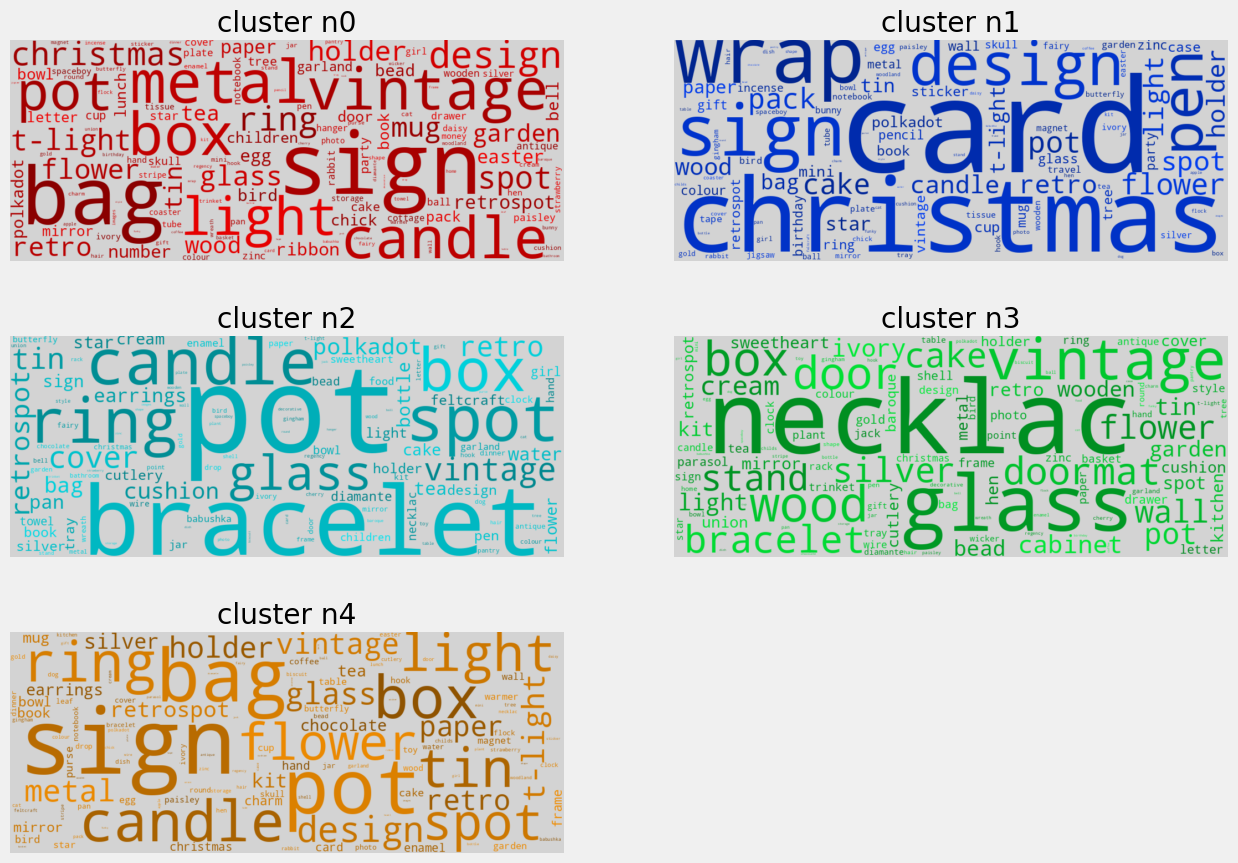

In [51]:

def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]

    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey',
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)



**c: _Principal Component Analysis_**

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [52]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

<ipython-input-55-ac2fe1275d00>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])


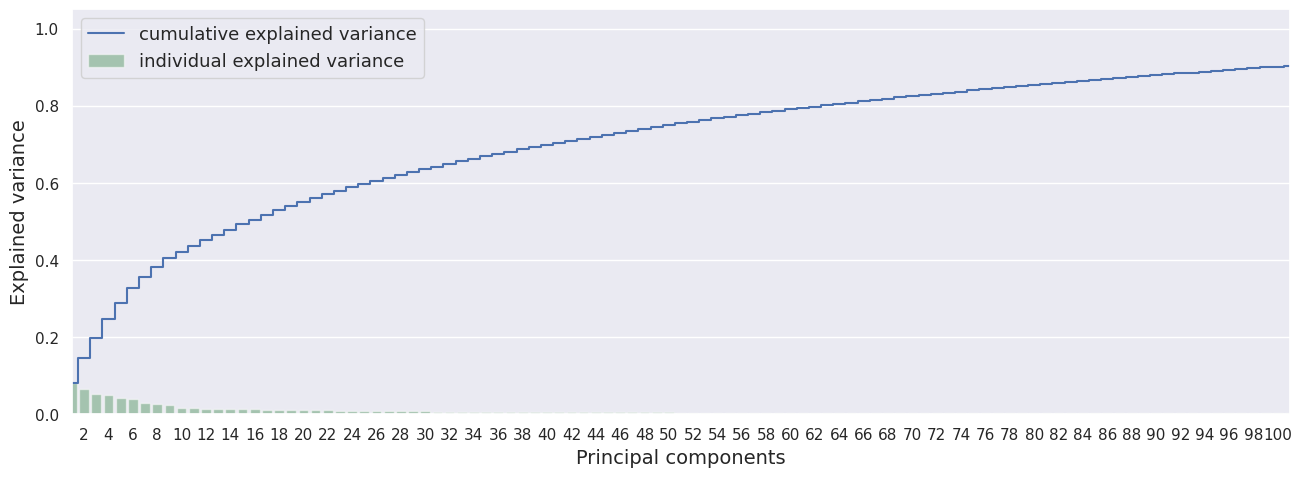

In [55]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(x=np.arange(1,matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance') # Pass x and y as named arguments
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [56]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

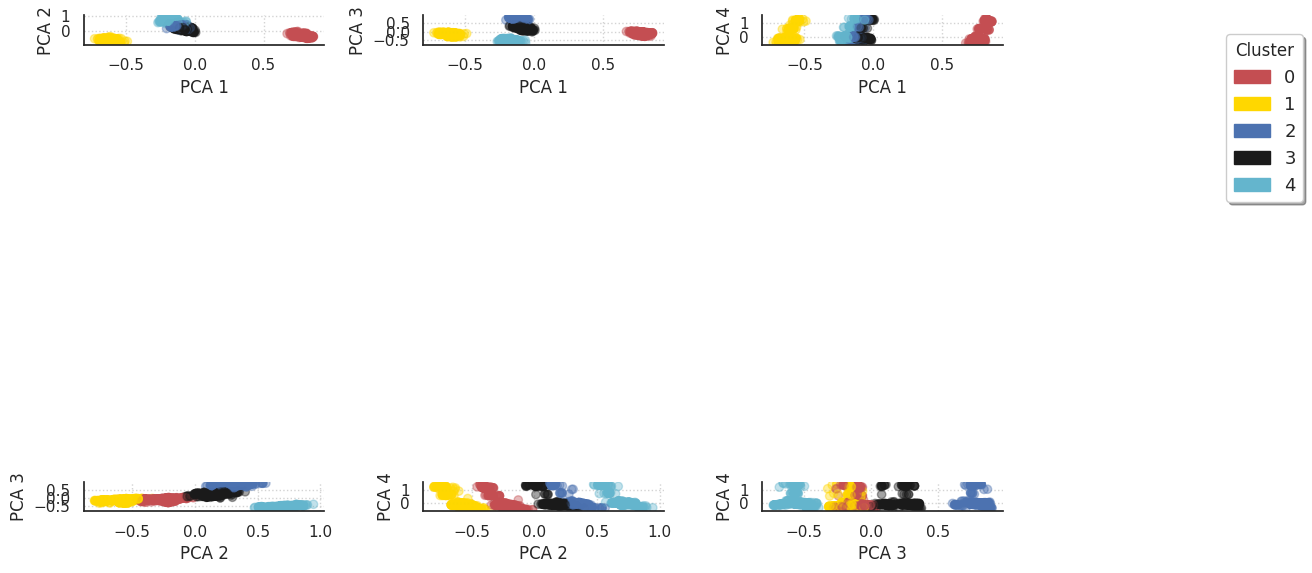

In [57]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):
        increment += 1
        ax = fig.add_subplot(3,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 9: break
    if increment == 9: break


comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97),
           title='Cluster',
           shadow = True, frameon = True, framealpha = 1,fontsize = 13,
           bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()

## Customer categories

Steps for generatin

* Formatting data
  * Grouping products  
  * Splitting of the dataset
  * Grouping orders  
* Creating customer categories
  * Data encoding
  * Creating categories



### Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable **categ_product** where I indicate the cluster of each product :

In [58]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description',
            'categ_product']][:10]

InvoiceNo                          Description  categ_product
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              4
1    536365                  WHITE METAL LANTERN              2
2    536365       CREAM CUPID HEARTS COAT HANGER              2
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              2
4    536365       RED WOOLLY HOTTIE WHITE HEART.              2
5    536365         SET 7 BABUSHKA NESTING BOXES              3
6    536365    GLASS STAR FROSTED T-LIGHT HOLDER              2
7    536366               HAND WARMER UNION JACK              4
8    536366            HAND WARMER RED POLKA DOT              0
9    536367        ASSORTED COLOUR BIRD ORNAMENT              0

#### Grouping products

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [59]:
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)


df_cleaned[['InvoiceNo', 'Description',
            'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:10]

InvoiceNo                          Description  categ_product  categ_0  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              4     0.00   
1    536365                  WHITE METAL LANTERN              2     0.00   
2    536365       CREAM CUPID HEARTS COAT HANGER              2     0.00   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              2     0.00   
4    536365       RED WOOLLY HOTTIE WHITE HEART.              2     0.00   
5    536365         SET 7 BABUSHKA NESTING BOXES              3     0.00   
6    536365    GLASS STAR FROSTED T-LIGHT HOLDER              2     0.00   
7    536366               HAND WARMER UNION JACK              4     0.00   
8    536366            HAND WARMER RED POLKA DOT              0    11.10   
9    536367        ASSORTED COLOUR BIRD ORNAMENT              0    54.08   

   categ_1  categ_2  categ_3  categ_4  
0      0.0     0.00      0.0     15.3  
1      0.0    20.34      0.0      0.0  
2      0.0    22.00      0.0      0.0  
3      0.0    20.34      0.0      0.0  
4      0.0    20.34      0.0      0.0  
5      0.0     0.00     15.3      0.0  
6      0.0    25.50      0.0      0.0  
7      0.0     0.00      0.0     11.1  
8      0.0     0.00      0.0      0.0  
9      0.0     0.00      0.0      0.0

In [61]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i)
    # Calculate the sum for each category
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    # Select only the relevant column from the result
    basket_price.loc[:, col] = temp[col]  # Assign only the 'col' column

# date of the order

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1      12347    537626        711.79    187.2    23.40   293.35   124.44   
2      12347    542237        475.39    130.5    84.34   169.20    38.25   
3      12347    549222        636.25    330.9    81.00   115.00    38.25   
4      12347    556201        382.52     74.4    41.40   168.76    19.90   
5      12348    539318        892.80    174.0   478.80     0.00   240.00   

   categ_4                   InvoiceDate  
1    83.40 2010-12-07 14:57:00.000000000  
2    53.10 2011-01-26 14:29:59.999999744  
3    71.10 2011-04-07 10:43:00.000000000  
4    78.06 2011-06-09 13:01:00.000000000  
5     0.00 2010-12-16 19:09:00.000000000

#### Splitting of data over time



In [62]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-06-14 11:52:59.999999744


In [64]:
import datetime

set_entrainement = basket_price[basket_price['InvoiceDate'] < pd.Timestamp(datetime.date(2011,10,1))]
set_test         = basket_price[basket_price['InvoiceDate'] >= pd.Timestamp(datetime.date(2011,10,1))]
basket_price = set_entrainement.copy(deep = True)

#### Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [65]:
# of visits and stats on cart amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min',
                                                                                   'max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      4  382.52  711.79  551.487500  2205.95  32.774995   
1      12348      3  227.44  892.80  495.746667  1487.24  32.543503   
2      12350      1  334.40  334.40  334.400000   334.40  40.909091   
3      12352      4  144.35  840.30  360.370000  1441.48  11.479868   
4      12353      1   89.00   89.00   89.000000    89.00  13.033708   

     categ_1    categ_2    categ_3    categ_4  
0  10.432693  33.831682  10.011106  12.949523  
1  45.940131   0.000000  21.516366   0.000000  
2  11.692584   0.000000  11.961722  35.436603  
3   0.707606   5.771846  78.356966   3.683714  
4   0.000000   0.000000  67.078652  19.887640

Finally, I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

In [66]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      4  382.52  711.79  551.487500  2205.95  32.774995   
1      12348      3  227.44  892.80  495.746667  1487.24  32.543503   
2      12350      1  334.40  334.40  334.400000   334.40  40.909091   
3      12352      4  144.35  840.30  360.370000  1441.48  11.479868   
4      12353      1   89.00   89.00   89.000000    89.00  13.033708   

     categ_1    categ_2    categ_3    categ_4  LastPurchase  FirstPurchase  
0  10.432693  33.831682  10.011106  12.949523             5            189  
1  45.940131   0.000000  21.516366   0.000000            70            180  
2  11.692584   0.000000  11.961722  35.436603           132            132  
3   0.707606   5.771846  78.356966   3.683714            84            118  
4   0.000000   0.000000  67.078652  19.887640            26             26

In [67]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. customers with single purchase: 1363/2832  (48.13%)


---
### Creation of customers categories

#### Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [69]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values
# Use .values to get the NumPy array representation of the DataFrame

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [71]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  2.81779661 272.08725282 513.47024753 371.71682104  27.44408398
  12.93232828  15.47304391  24.26284749  19.89551582]


In [72]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

<ipython-input-74-f562c00a9283>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])


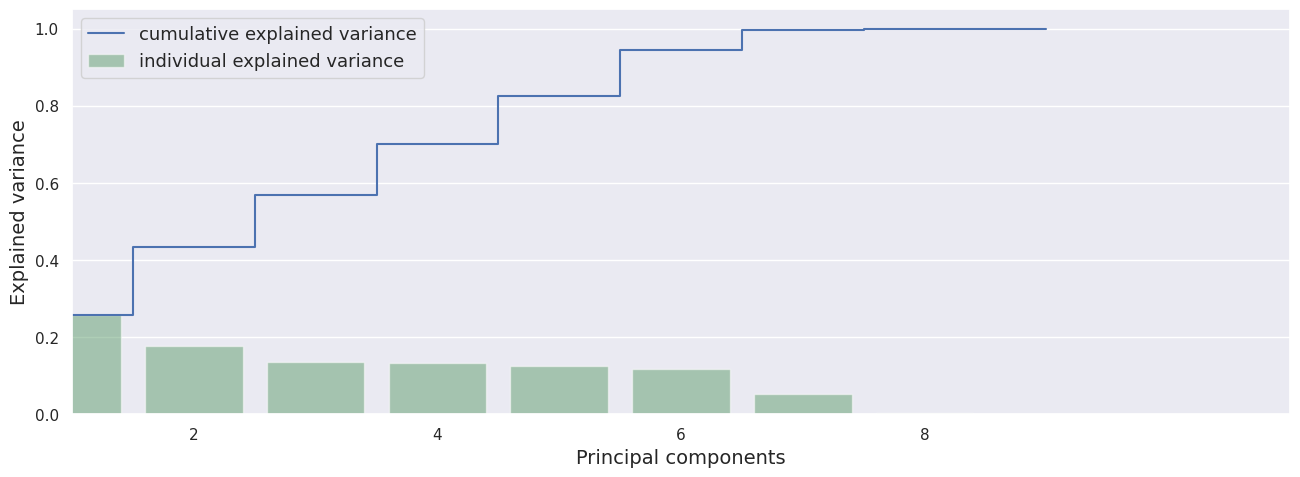

In [74]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')

# Create a DataFrame for the bar plot
df_bar = pd.DataFrame({'PC': np.arange(1, matrix.shape[1] + 1),
                       'Explained Variance': pca.explained_variance_ratio_})

# Use keyword arguments to specify x and y
sns.barplot(x='PC', y='Explained Variance', data=df_bar, alpha=0.5, color='g',
            label='individual explained variance')

plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

-----
#### Creating customer categories

At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 11 clusters:

In [75]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.206


At first, I look at the number of customers in each cluster:

In [76]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

Empty DataFrame
Columns: []
Index: [number of clients]

**a / _Report via the PCA_**



In [77]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

<ipython-input-78-f52f2c7204c7>:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


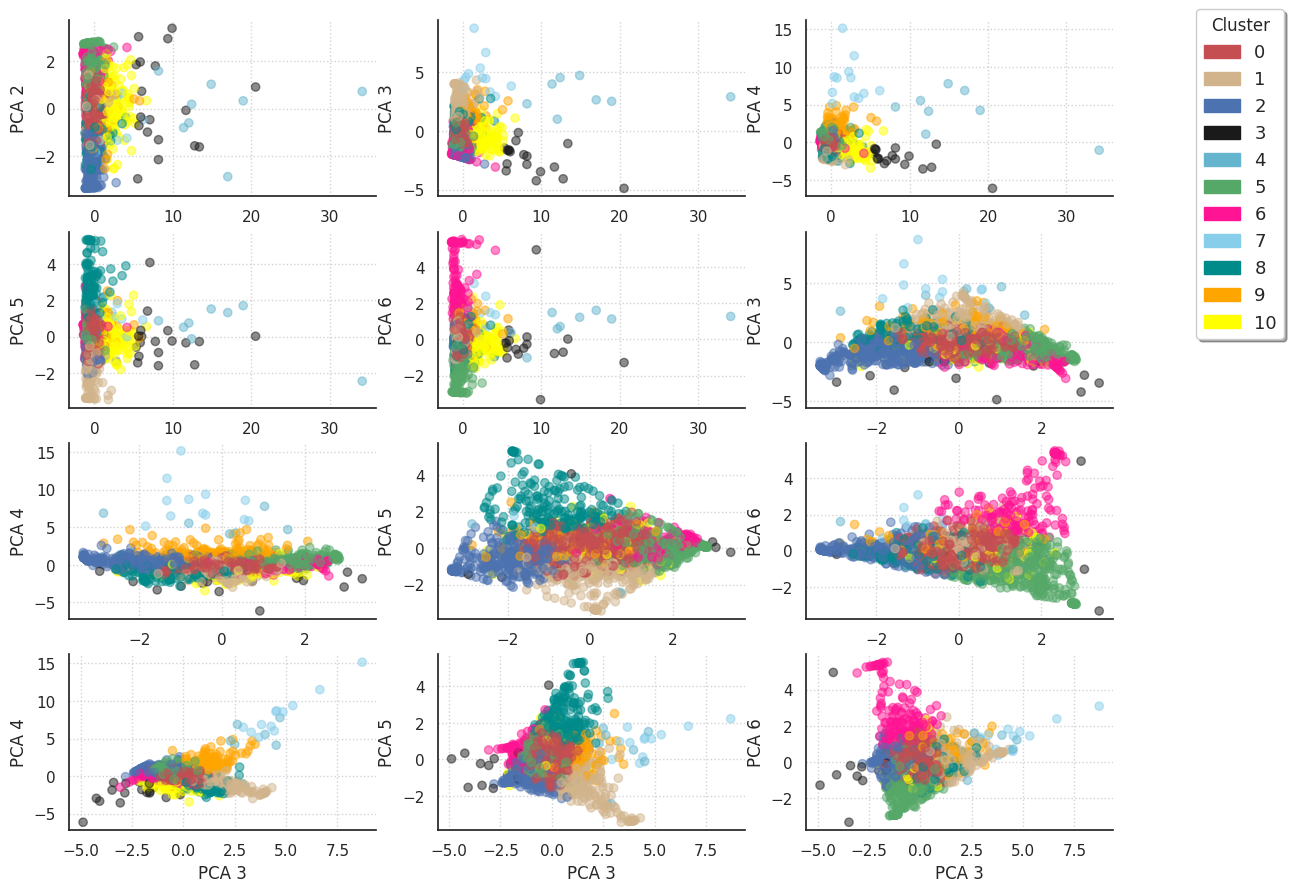

In [78]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan',
                   9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 12: break
    if increment == 12: break

#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()


**b _Score of the silhouette intra-cluster_**

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

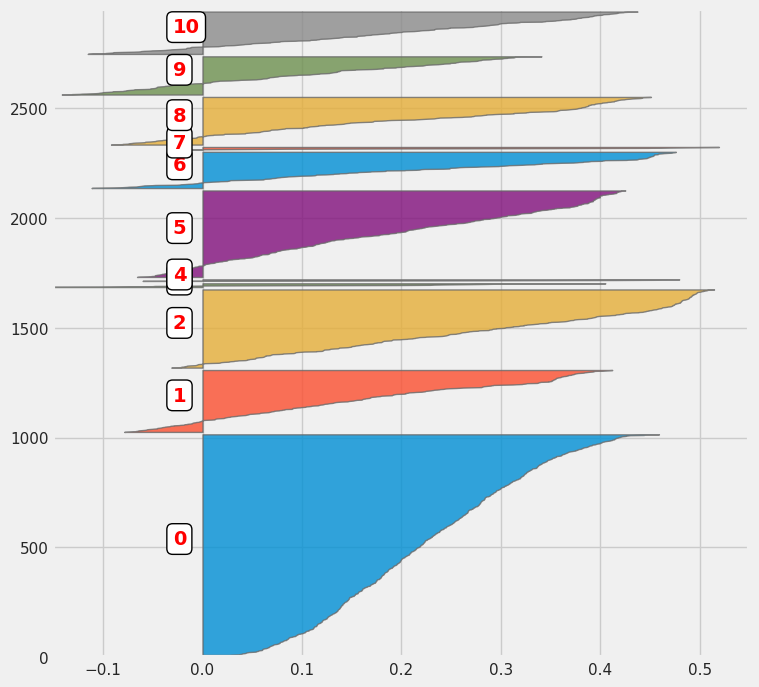

In [79]:
#sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silhouette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values,
                           clusters_clients)

**c/ _Customers morphotype_**

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

In [80]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [81]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 2832


In [82]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

cluster      count          min          max         mean          sum  \
0       5.0   1.908861   221.373848   309.503089   263.106597   513.705848   
1       6.0   1.795181   200.893554   305.464096   246.173948    472.93512   
2       8.0   1.889908   205.428945   345.271651   263.149531   596.506101   
3       2.0   2.061625   207.114034   320.005378   257.576289   549.596218   
4       1.0   1.890459   196.225336   296.587915   244.246279   477.286113   
5       0.0   2.321074   235.831342   398.598887   313.345757   738.147773   
6      10.0   1.603093   863.693041  1163.946191  1005.450882  1726.168149   
7       3.0   1.555556  2608.991667  3194.261111  2893.337315  4527.955556   
8       9.0      10.92     106.8164   997.894057   445.441921  4811.069657   
9       7.0  46.333333      29.0475      2668.97   552.228751   22123.9675   
10      4.0       13.0       587.38   14598.7025   5315.57139  54205.19125   

      categ_0    categ_1    categ_2    categ_3    categ_4  size  
0   60.941438  11.573762   6.981354   8.663235  11.843995   395  
1   17.201637  57.314255   6.319908   8.147295  11.016906   166  
2   14.374575   6.102281   52.37415  15.263152  11.911993   218  
3    10.61913   4.361644   8.300065  66.786225   9.954787   357  
4   17.729691   7.583974   8.772636  14.290845  51.622855   283  
5   27.399554  12.711076  16.812877  22.343321  20.737028  1006  
6   27.634219  11.568074  15.862595  24.339551  20.595561   194  
7   26.563315  15.080135  14.214978  33.237077  10.904495    18  
8   27.977942  11.636526  15.064007  25.036323  20.303872   175  
9   29.129515  10.370184  12.148686  27.826314  20.525301    12  
10   25.41158   5.132084  15.078088  26.350349    28.0279     8

**d _Customers morphology garphical representation_**



In [85]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]

        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True,
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)

        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = ["{:.0f}".format(x) for x in grid]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])

        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


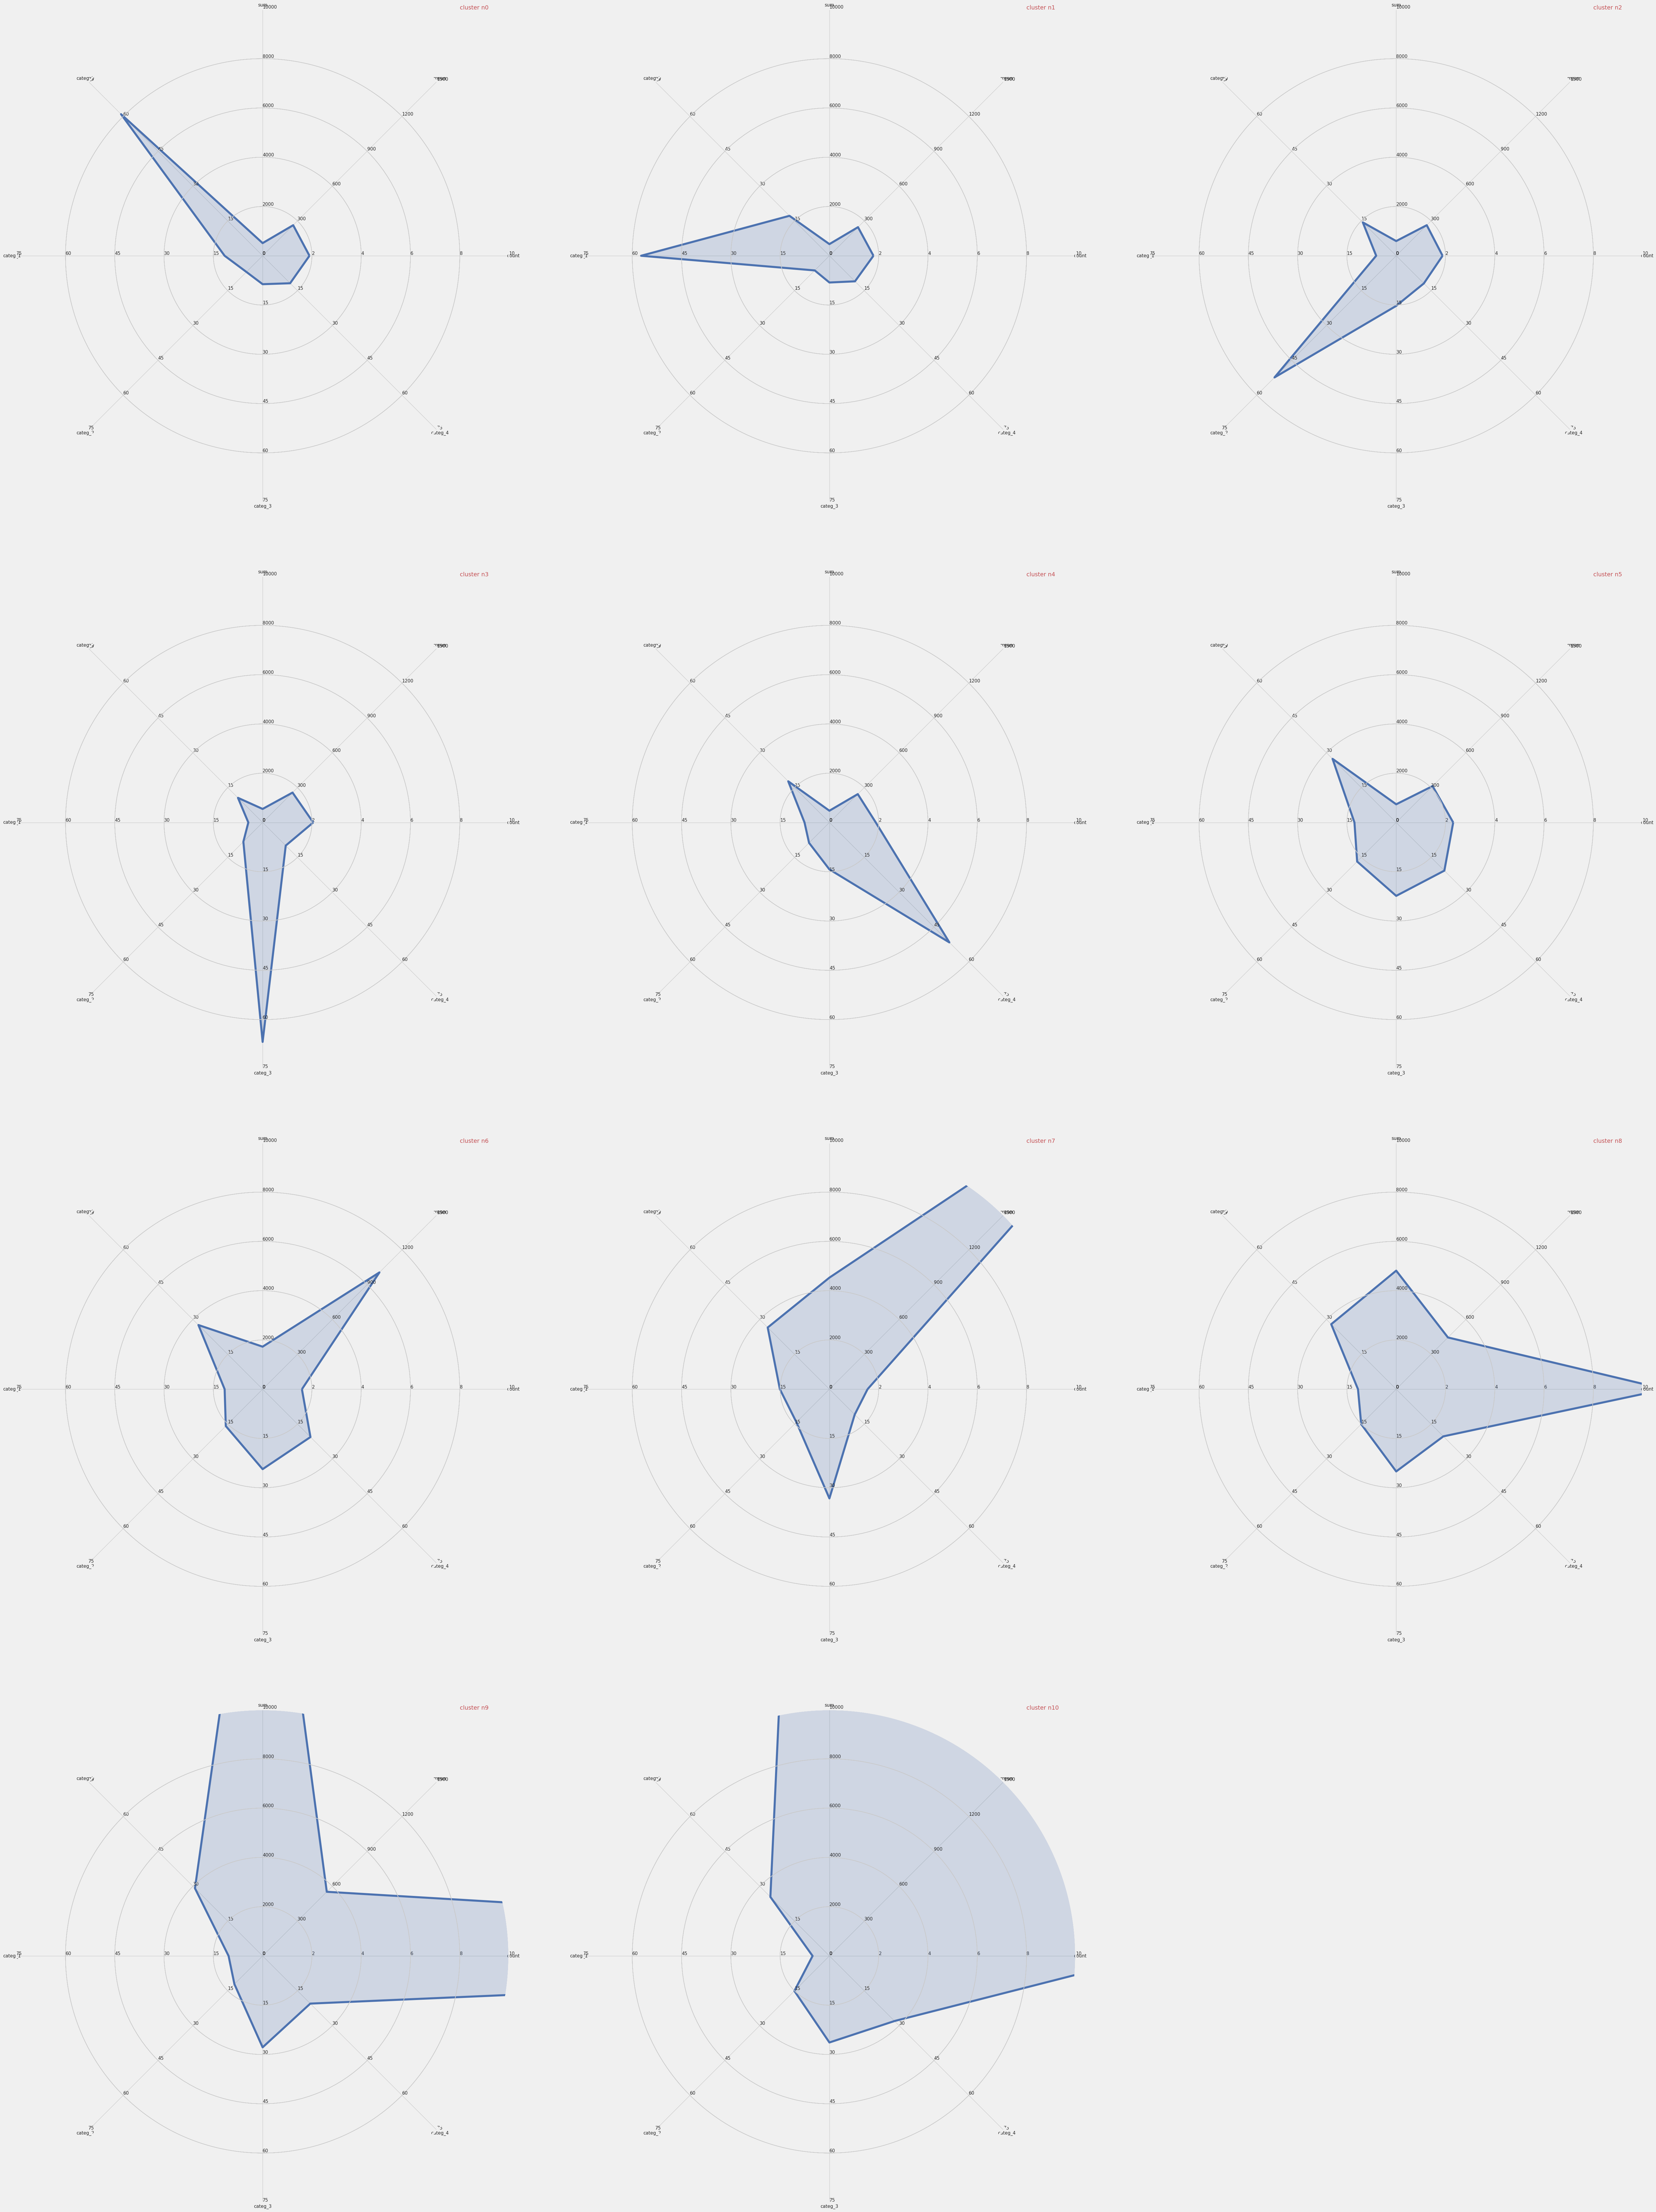

In [86]:
fig = plt.figure(figsize=(50,50))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y]
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])
    #print (data)
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=5.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster n{}'.format(index[ind]), color = 'r')
    ind += 1


____

## Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers:

In [87]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))


In [88]:
selected_customers.head()

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      4  382.52  711.79  551.487500  2205.95  32.774995   
1      12348      3  227.44  892.80  495.746667  1487.24  32.543503   
2      12350      1  334.40  334.40  334.400000   334.40  40.909091   
3      12352      4  144.35  840.30  360.370000  1441.48  11.479868   
4      12353      1   89.00   89.00   89.000000    89.00  13.033708   

     categ_1    categ_2    categ_3    categ_4  LastPurchase  FirstPurchase  \
0  10.432693  33.831682  10.011106  12.949523             5            189   
1  45.940131   0.000000  21.516366   0.000000            70            180   
2  11.692584   0.000000  11.961722  35.436603           132            132   
3   0.707606   5.771846  78.356966   3.683714            84            118   
4   0.000000   0.000000  67.078652  19.887640            26             26   

   cluster  
0        0  
1        6  
2        0  
3        2  
4        2

In [89]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [90]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### Support Vector Machine Classifier (SVC)



In [91]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [92]:
svc.grid_fit(X = X_train, Y = Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [93]:
svc.grid_predict(X_test, Y_test)

Precision: 81.13 % 


Note that for every run precision value may change

___
#### Confusion matrix


In [94]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


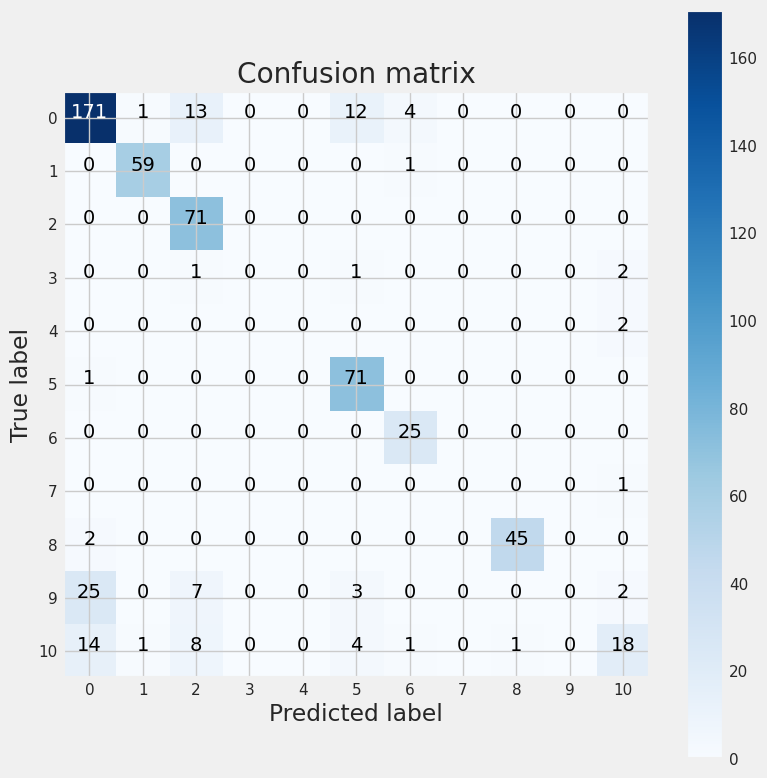

In [95]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')


----------------
#### Learning curve



In [96]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

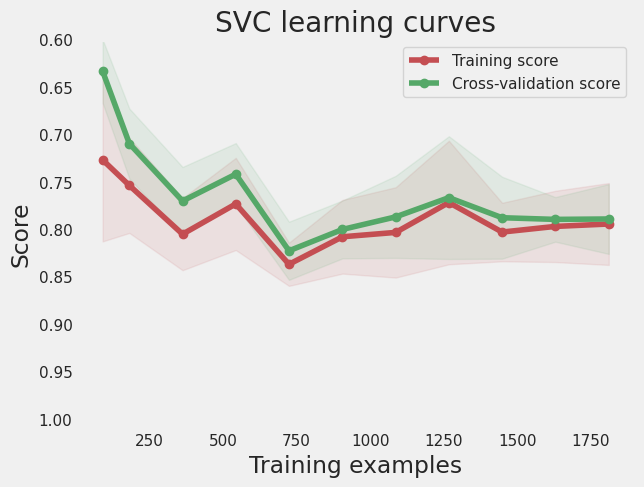

In [97]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

## Revised approach

### Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

In [98]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Precision: 86.07 % 


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Then, I plot the learning curve to have a feeling of the quality of the model:

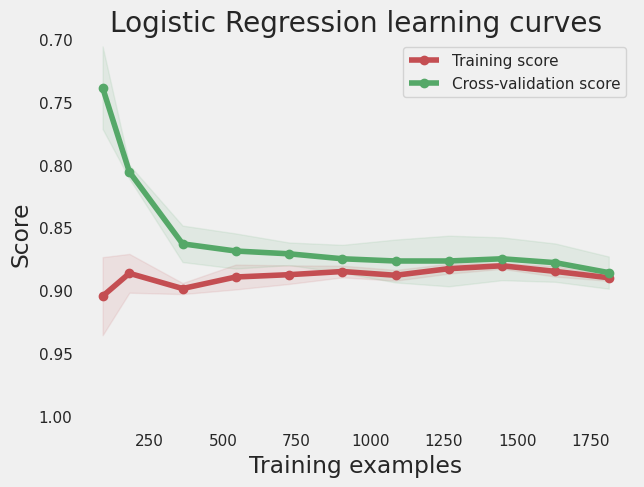

In [99]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

----
### k-Nearest Neighbors

In [100]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 75.66 % 


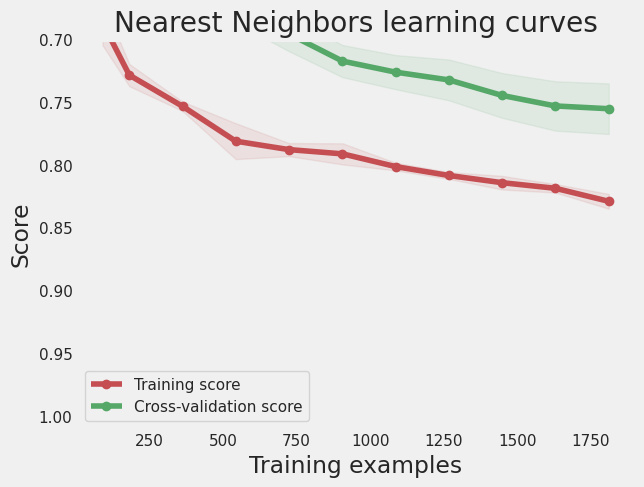

In [101]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Decision Tree

In [102]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 79.01 % 


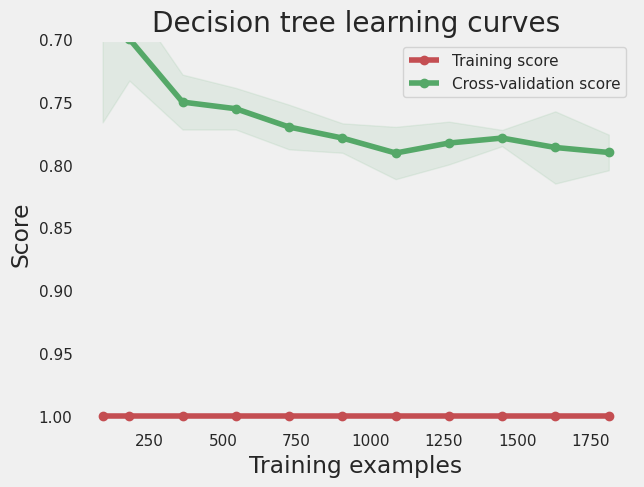

In [103]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Random Forest

In [104]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 87.30 % 


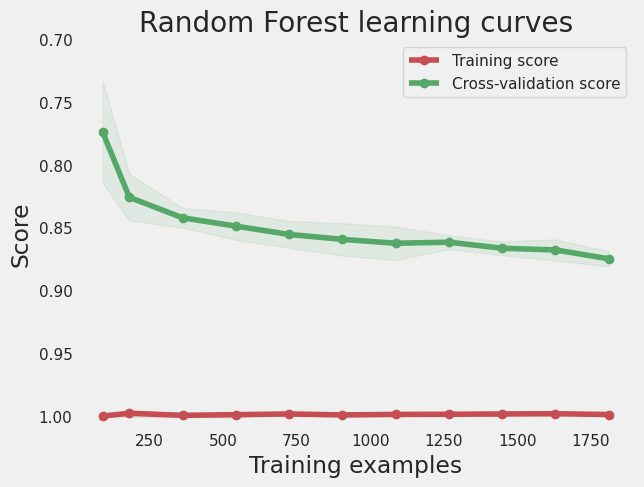

In [105]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBoost Classifier

In [106]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 48.15 % 


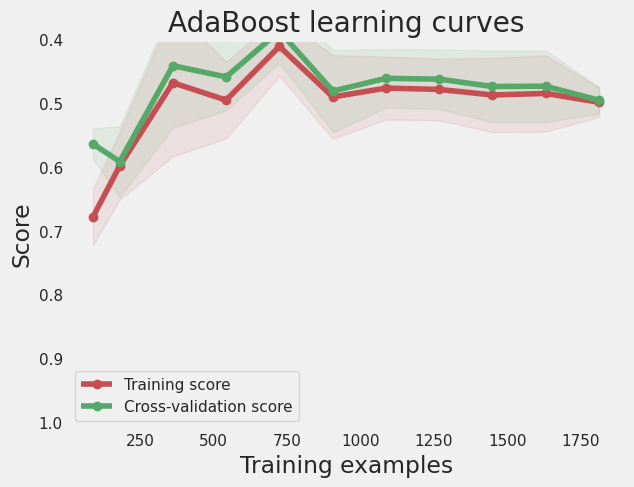

In [107]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

###  Gradient Boosting Classifier

In [108]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 87.48 % 


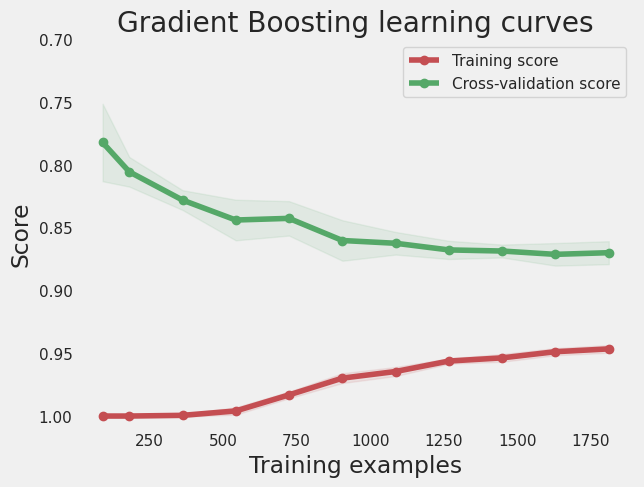

In [109]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

------
## Best approach


In [110]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [111]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')

and train it:

In [112]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [113]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 87.83 % 


Note that when defining the `votingC` classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the *Random Forest*, the *k-Nearest Neighbors* and the *Gradient Boosting* classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

___
## Testing predictions


In [122]:
basket_price = set_test.copy(deep = True)

In [123]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

Empty DataFrame
Columns: [CustomerID, count, min, max, mean, sum, categ_0, categ_1, categ_2, categ_3, categ_4]
Index: []

In [124]:
# Check if transactions_per_user is empty and handle accordingly
if transactions_per_user.empty:
    print("Warning: transactions_per_user is empty. No scaling performed.")
    scaled_test_matrix = None  # Or handle the empty case as needed
else:
    list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
    matrix_test = transactions_per_user[list_cols].to_numpy()
    scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [119]:
Y = kmeans.predict(scaled_test_matrix)

ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [120]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained earlier

In [121]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine


ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by LinearSVC.

Finally, as anticipated in revised approach, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix *Random Forest*, *Gradient Boosting* and *k-Nearest Neighbors* predictions because this leads to a slight improvement in predictions:

In [ ]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 76.83 % 


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
